In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
sys.path.append("..")
from src.dataset import SIModel
from src.approx_bc import abc_rejection_sampler
import seaborn as sns
from scipy.stats import norm, lognorm, multivariate_normal

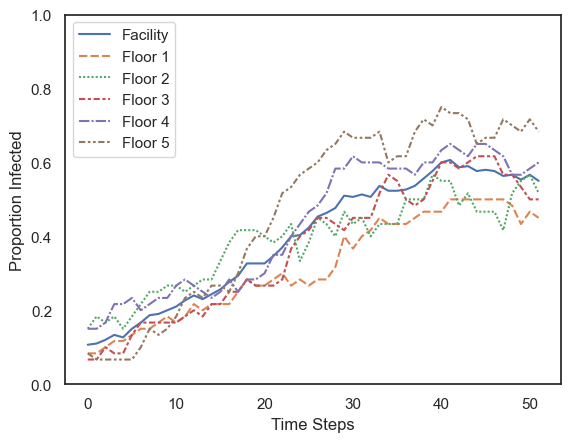

In [8]:
sns.set_theme()
sns.set_style("white")

beta_true = [0.05, .1, .2, .3, .4, .5, 5]
alpha = 0.1
gamma = 0.05
heterogeneous = True
N = 300 # consider increasing
T = 52
K = 30
data_seed = 31
prior_mu = [-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]
prior_sigma = [1, 1, 1, 1, 1, 1, 1]

si_model = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False, flatten=False,
                  observed_seed=data_seed)
x_o = si_model.get_observed_data()

data = x_o[:6,:]

data = pd.DataFrame(data = data.T, columns=["Facility"] + [f"Floor {i}" for i in range(1,6)])

sns.lineplot(data)
plt.ylim((0,1))
plt.xlabel("Time Steps")
plt.ylabel("Proportion Infected")
plt.show()

## Prior

### Prior Predictive Check

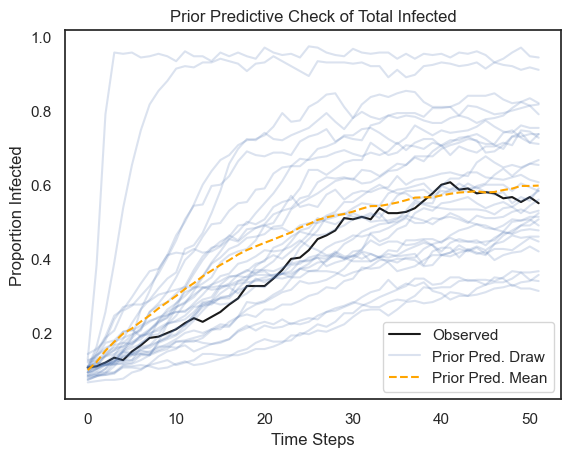

In [9]:
prior = norm(prior_mu, prior_sigma)
prior_sample = np.exp(prior.rvs(size=(K, 7), random_state=2))
prior_predictive = np.empty((K, 7 ,T))

for i in range(K):
    si_model = SIModel(alpha, gamma, prior_sample[i], 
                    heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False, flatten=False,
                  observed_seed=None)
    x_rep = si_model.get_observed_data(i)
    prior_predictive[i] =  np.array(x_rep)
prp_mean = prior_predictive.mean(0)[0]

labels = ["Prior Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
plt.plot(I_o, label="Observed", color="k")
plt.plot(prior_predictive[:,0,:].T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(prp_mean, label="Prior Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("Prior Predictive Check of Total Infected")
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.show()

### NPE

In [10]:
df_npe = pd.read_csv("npe_het.csv")
df_npe["mu"] = df_npe["mu"].apply(lambda x: eval(x)[0])
df_npe["sigma"] = df_npe["sigma"].apply(lambda x: eval(x))
df_npe

,N,d_model,mean_field,mu,n_sample,prior_mu,prior_sigma,sigma,val_loss,weight_decay
0,300,64,False,"[-3.074918270111084, -1.5437170267105103, -1.4...",500,"[-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]","[1, 1, 1, 1, 1, 1, 1]","[[0.1560225784778595, -0.13995875418186188, -0...",7.206876,0.02
1,300,64,False,"[-3.005905866622925, -2.0647132396698, -1.5440...",1000,"[-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]","[1, 1, 1, 1, 1, 1, 1]","[[0.14479154348373413, -0.15495739877223969, -...",6.018443,0.02
2,300,80,False,"[-2.917301654815674, -2.0416808128356934, -1.5...",2000,"[-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]","[1, 1, 1, 1, 1, 1, 1]","[[0.10882394015789032, -0.11664779484272003, -...",6.007447,0.01
3,300,56,False,"[-2.9243125915527344, -2.1539695262908936, -1....",4000,"[-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]","[1, 1, 1, 1, 1, 1, 1]","[[0.10477440059185028, -0.1165282353758812, -0...",5.983428,0.01
4,300,80,False,"[-2.92686128616333, -2.248863458633423, -1.684...",6000,"[-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]","[1, 1, 1, 1, 1, 1, 1]","[[0.12034208327531815, -0.12657757103443146, -...",5.728621,0.01


In [11]:
r = df_npe.loc[4]
for j in range(7):
    # print(beta_true[j])
    m = r["mu"][j]
    s = r["sigma"][j][j]
    print(np.exp(m + s/2))
    print(m)
    print(np.sqrt(s))
    print("****")

0.05688689705905119
-2.92686128616333
0.3469035648062991
****
0.14007662127538542
-2.248863458633423
0.7527253780411298
****
0.2265113728873097
-1.6842628717422485
0.6313521170403243
****
0.24277779224726304
-1.6017621755599976
0.6101696262041242
****
0.3608829275840042
-1.1307098865509033
0.47224614976431145
****
0.4729986451392747
-0.8366464376449585
0.4194846427502575
****
5.037826360703589
1.0925225019454956
1.0241603482586663
****


In [13]:
df_npe

,N,d_model,mean_field,mu,n_sample,prior_mu,prior_sigma,sigma,val_loss,weight_decay
0,300,64,False,"[-3.074918270111084, -1.5437170267105103, -1.4...",500,"[-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]","[1, 1, 1, 1, 1, 1, 1]","[[0.1560225784778595, -0.13995875418186188, -0...",7.206876,0.02
1,300,64,False,"[-3.005905866622925, -2.0647132396698, -1.5440...",1000,"[-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]","[1, 1, 1, 1, 1, 1, 1]","[[0.14479154348373413, -0.15495739877223969, -...",6.018443,0.02
2,300,80,False,"[-2.917301654815674, -2.0416808128356934, -1.5...",2000,"[-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]","[1, 1, 1, 1, 1, 1, 1]","[[0.10882394015789032, -0.11664779484272003, -...",6.007447,0.01
3,300,56,False,"[-2.9243125915527344, -2.1539695262908936, -1....",4000,"[-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]","[1, 1, 1, 1, 1, 1, 1]","[[0.10477440059185028, -0.1165282353758812, -0...",5.983428,0.01
4,300,80,False,"[-2.92686128616333, -2.248863458633423, -1.684...",6000,"[-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]","[1, 1, 1, 1, 1, 1, 1]","[[0.12034208327531815, -0.12657757103443146, -...",5.728621,0.01


In [15]:
# df_npe = df_npe.explode(["mu", "sd", "Beta"])
# df_npe["mean"] = df_npe["mean"].astype(float)
# df_npe["sd"] = df_npe["sd"].astype(float)
# df_npe[".05"] = np.exp(norm(df_npe["mean"], df_npe["sd"]).ppf(0.05))
# df_npe[".95"] = np.exp(norm(df_npe["mean"], df_npe["sd"]).ppf(0.95))
# df_npe["Posterior Mean"] = np.exp(df_npe["mean"] + df_npe["sd"]**2/2)

## Posterior Predictive Checks

In [16]:
df_npe

,N,d_model,mean_field,mu,n_sample,prior_mu,prior_sigma,sigma,val_loss,weight_decay
0,300,64,False,"[-3.074918270111084, -1.5437170267105103, -1.4...",500,"[-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]","[1, 1, 1, 1, 1, 1, 1]","[[0.1560225784778595, -0.13995875418186188, -0...",7.206876,0.02
1,300,64,False,"[-3.005905866622925, -2.0647132396698, -1.5440...",1000,"[-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]","[1, 1, 1, 1, 1, 1, 1]","[[0.14479154348373413, -0.15495739877223969, -...",6.018443,0.02
2,300,80,False,"[-2.917301654815674, -2.0416808128356934, -1.5...",2000,"[-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]","[1, 1, 1, 1, 1, 1, 1]","[[0.10882394015789032, -0.11664779484272003, -...",6.007447,0.01
3,300,56,False,"[-2.9243125915527344, -2.1539695262908936, -1....",4000,"[-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]","[1, 1, 1, 1, 1, 1, 1]","[[0.10477440059185028, -0.1165282353758812, -0...",5.983428,0.01
4,300,80,False,"[-2.92686128616333, -2.248863458633423, -1.684...",6000,"[-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]","[1, 1, 1, 1, 1, 1, 1]","[[0.12034208327531815, -0.12657757103443146, -...",5.728621,0.01


In [17]:
mu = np.array(df_npe.loc[4]["mu"])
sigma = np.array(df_npe.loc[4]["sigma"])

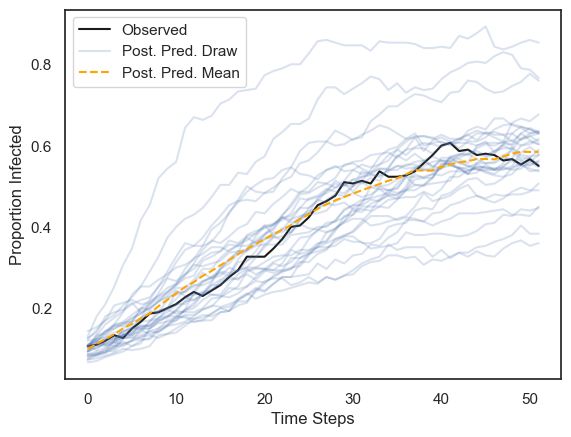

In [18]:
neural_posterior = multivariate_normal(mu, sigma)
K = 30
npe_sample = np.exp(neural_posterior.rvs(size=K, random_state=2))
posterior_predictive = np.empty((K, 7, T))

si_model = SIModel(alpha, gamma, beta_true, 
                   heterogeneous, prior_mu, prior_sigma, 
                   N, T, summarize=False, observed_seed=31,
                   flatten=False)
x_o = si_model.get_observed_data()

for i in range(K):
    si_model = SIModel(alpha, gamma, npe_sample[i], 
                   heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False, observed_seed=31, flatten=False)
                   # pi = [.2, 1, 1, 1, 1, 1, 1])
    x_rep = si_model.get_observed_data(i)
    posterior_predictive[i] =  np.array(x_rep)
pp_mean = posterior_predictive.mean(0)[0]

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive[:,0,:].T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
# plt.title("NPE Posterior Predictive Check")
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.show()

In [19]:
floor_ppc = pd.DataFrame(data = posterior_predictive.mean(0)[:6].T, 
             columns=["Facility"] + [f"Floor {i}" for i in range(1,6)])

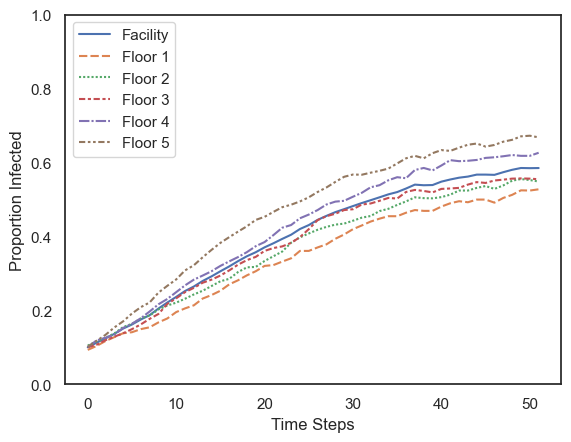

In [20]:
sns.lineplot(floor_ppc)
plt.legend()
plt.ylim(0,1)
plt.xlabel("Time Steps")
plt.ylabel("Proportion Infected")
plt.show()

In [21]:
pis = [
    [.1, 1, 1, 1, 1, 1, 1],
    [.75, .75, .75, .75, .75, .75, .75],
    [.5, .5, .5, .5, .5, .5, .5],
    [.25, .25, .25, .25, .25, .25, .25]
]
intervention = np.empty((K, len(pis), T))
for j, pi in enumerate(pis):
    for i in range(K):
        si_model = SIModel(alpha, gamma, npe_sample[i], 
                    heterogeneous, prior_mu, prior_sigma,
                    N, T, summarize=False, observed_seed=31, flatten=False,
                    pi=pi)
        x_rep = si_model.get_observed_data(i)
        intervention[i,j] =  np.array(x_rep)[0]
sds = intervention.std(0)
intervention = intervention.mean(0)

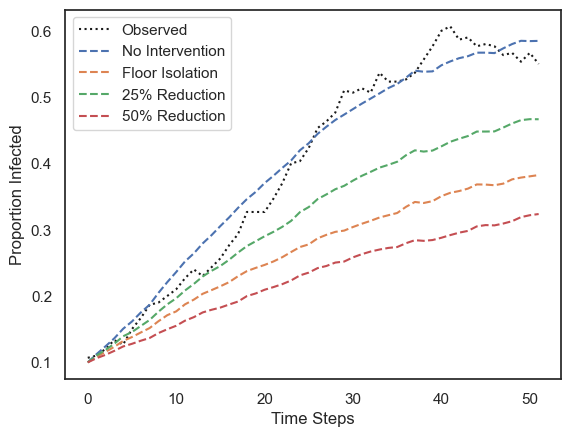

In [22]:
plt.plot(I_o, label="Observed", color="k", linestyle=":")
plt.plot(pp_mean, label="No Intervention", linestyle="--")
plt.plot(intervention[0], label="Floor Isolation", linestyle="--")
plt.plot(intervention[1], label="25% Reduction", linestyle="--")
plt.plot(intervention[2], label="50% Reduction", linestyle="--")
# plt.plot(intervention[3], label="75% Reduction", linestyle="--")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Proportion Infected")
# plt.title("Interventions in Heterogeneous Transmission")
plt.show()

## ABC

In [ ]:
# compare to [[0.057 0.149 0.278 0.262 0.404 0.488 4.464]] for NPE trained on 1k samples
# [[0.059 0.176 0.243 0.246 0.327 0.531 4.448]] trained on 2k samples

In [ ]:
# compare to [0.141 0.563 0.285 0.471 0.445 0.178 0.844] for NPE

In [23]:
abc_data = {"summarize":[], "epsilon":[], "simulations":[]}
abc_samples = []

args = [(False, [2.5, 2.3, 2.1, 1.9, 1.7]),
        (True, [0.3, 0.275, 0.25, 0.2, .15])]
for summarize, es in args:
    for epsilon in es:
        si_model = SIModel(alpha, gamma, beta_true, 
                        heterogeneous, prior_mu, prior_sigma, 
                       N, T, summarize, observed_seed=31, flatten=False)
        prior_sampler = lambda: si_model.sample_logbeta(1)
        simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
        x_o = si_model.get_observed_data()
        S = 100
        print(f"epsilon: {epsilon}")
        posterior_sample, errors = abc_rejection_sampler(
            S, epsilon, prior_sampler, simulator, x_o, max_attempts=40000,
            summarize=summarize
            )
        print("***")
        abc_data["summarize"].append(summarize)
        abc_data["epsilon"].append(epsilon)
        abc_data["simulations"].append((errors > 0).sum())
        abc_samples.append(posterior_sample)   

epsilon: 2.5
Time lapsed: 11.37 seconds
With tolerance 2.5, acceptance rate: 0.144718
Total number of attempts: 691
***
epsilon: 2.3
Time lapsed: 13.17 seconds
With tolerance 2.3, acceptance rate: 0.124533
Total number of attempts: 803
***
epsilon: 2.1
Time lapsed: 21.75 seconds
With tolerance 2.1, acceptance rate: 0.075758
Total number of attempts: 1,320
***
epsilon: 1.9
Time lapsed: 33.98 seconds
With tolerance 1.9, acceptance rate: 0.047893
Total number of attempts: 2,088
***
epsilon: 1.7
Attempts: 5,000
Time lapsed: 96.34 seconds
With tolerance 1.7, acceptance rate: 0.017479
Total number of attempts: 5,721
***
epsilon: 0.3
Time lapsed: 6.31 seconds
With tolerance 0.3, acceptance rate: 0.267380
Total number of attempts: 374
***
epsilon: 0.275
Time lapsed: 7.56 seconds
With tolerance 0.275, acceptance rate: 0.220751
Total number of attempts: 453
***
epsilon: 0.25
Time lapsed: 11.93 seconds
With tolerance 0.25, acceptance rate: 0.141844
Total number of attempts: 705
***
epsilon: 0.2
T

In [43]:
df_abc = pd.DataFrame(abc_data)
abc_posterior = np.array(abc_samples)
# df_abc = df_abc.join(pd.DataFrame(data = np.exp(abc_posterior).mean(1)))
df_abc = df_abc.join(pd.DataFrame(data = abc_posterior.mean(1)))
df_abc = df_abc.melt(id_vars=["summarize", "epsilon", "simulations"], var_name="Beta", value_name="mean")
df_abc["Method"] = df_abc["summarize"].apply(lambda x: "ABC-S" if x else "ABC")

In [44]:
df_abc2 = pd.DataFrame(abc_data).join(pd.DataFrame(data = abc_posterior.std(1)))
df_abc2 = df_abc2.melt(id_vars=["summarize", "epsilon", "simulations"], var_name="Beta", value_name="sd")
df_abc["sd"] = df_abc2["sd"]

In [45]:
df_abc["posterior mean"] = np.exp(df_abc["mean"] + df_abc["sd"]**2 / 2)

In [172]:
df_abc.columns

Index(['summarize', 'epsilon', 'simulations', 'Beta', 'mean', 'Method', 'sd',
       'posterior mean'],
      dtype='object')

In [226]:
df_abc[(df_abc["summarize"] == False) & (df_abc["simulations"] == 1085)]

,summarize,epsilon,simulations,Beta,mean,Method,sd,posterior mean
1,False,2.2,1085,0,-2.925552,ABC,0.416123,0.058486
9,False,2.2,1085,1,-1.884683,ABC,0.774412,0.204983
17,False,2.2,1085,2,-1.683483,ABC,0.751799,0.246380
25,False,2.2,1085,3,-1.737867,ABC,0.801453,0.242512
33,False,2.2,1085,4,-1.412191,ABC,0.732823,0.318646
41,False,2.2,1085,5,-1.291187,ABC,0.815057,0.383265
49,False,2.2,1085,6,1.049346,ABC,0.950229,4.485340


In [7]:
np.exp(-1.5)

0.22313016014842982

In [46]:
df_abc.sort_values(["epsilon", "Beta"])

,summarize,epsilon,simulations,Beta,mean,Method,sd,posterior mean
7,True,0.135,6915,0,-2.745469,ABC-S,0.323146,0.067660
15,True,0.135,6915,1,-2.285207,ABC-S,0.637924,0.124714
23,True,0.135,6915,2,-1.800694,ABC-S,0.684232,0.208752
31,True,0.135,6915,3,-1.909266,ABC-S,0.672306,0.185766
39,True,0.135,6915,4,-1.558988,ABC-S,0.723825,0.273343
47,True,0.135,6915,5,-1.067950,ABC-S,0.492609,0.388051
55,True,0.135,6915,6,0.879673,ABC-S,0.901301,3.617721
5,True,0.150,4789,0,-2.713879,ABC-S,0.347638,0.070408
13,True,0.150,4789,1,-2.182217,ABC-S,0.692367,0.143341
21,True,0.150,4789,2,-1.855937,ABC-S,0.793573,0.214154


### Visualization

In [358]:
def het_plotter(j, mode="mean"):
    m = np.array([r["mu"][j] for _, r in df_npe.iterrows()])
    s = np.array([r["sigma"][j][j] for _, r in df_npe.iterrows()])
    df_viz = pd.DataFrame({
    "Method": ["NPE" for _ in range(4)],
    "simulations": df_npe["n_sample"],
    "mean": m,
    "sd": np.sqrt(s),
    "posterior mean": np.exp(m + s/2)
    })
    df_viz = pd.concat([df_abc[df_abc["Beta"] == j][["Method", "simulations", "mean", "sd", "posterior mean"]],
            df_viz])
    ax = sns.lineplot(df_viz, x="simulations", y=mode, hue="Method", marker="o")
    if mode == "mean":
        ax.axhline(y = np.log(beta_true[j]), color="k", linestyle="--")
        plt.ylabel("Posterior Mean")
    elif mode == "posterior mean":
        ax.axhline(y = beta_true[j], color="k", linestyle="--")
        plt.ylabel("Posterior Mean")
    elif mode == "sd":
        plt.ylabel("Posterior Standard Deviation")
    plt.xscale("log")
    plt.xlabel("Simulations")
    plt.legend(title=None)
    # plt.title(rf"Simulation-based Inference of $\beta_{j}$")
    ax.set_xticks([500, 1000, 2000, 4000])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.show()

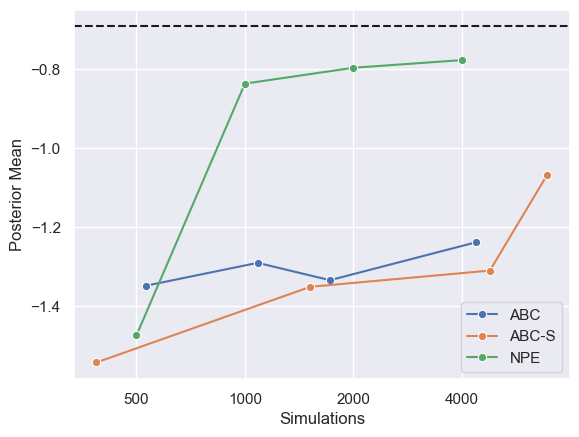

In [359]:
het_plotter(5)

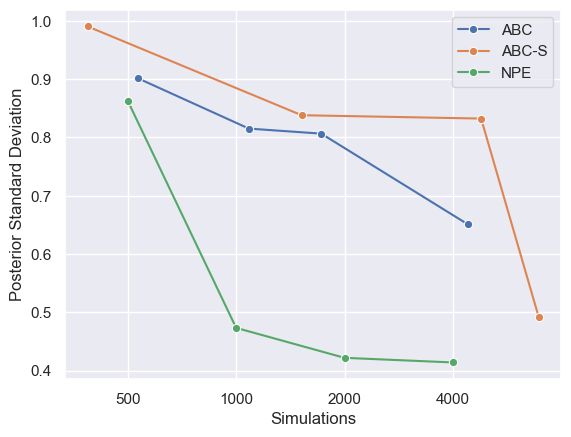

In [360]:
het_plotter(5, "sd")

In [241]:
# for j in range(7):
#     het_plotter(j, "posterior mean")

In [242]:
# for j in range(7):
#     het_plotter(j)

In [243]:
# for j in range(7):
#     het_plotter(j, "sd")

In [219]:
df_abc[(df_abc["summarize"] == True) & (df_abc["epsilon"] == 0.15)]

,summarize,epsilon,simulations,Beta,mean,Method,sd,posterior mean
5,True,0.15,4789,0,-2.713879,ABC-S,0.347638,0.070408
13,True,0.15,4789,1,-2.182217,ABC-S,0.692367,0.143341
21,True,0.15,4789,2,-1.855937,ABC-S,0.793573,0.214154
29,True,0.15,4789,3,-1.846599,ABC-S,0.728471,0.205715
37,True,0.15,4789,4,-1.512544,ABC-S,0.822956,0.309154
45,True,0.15,4789,5,-1.310823,ABC-S,0.832263,0.381177
53,True,0.15,4789,6,0.781603,ABC-S,0.917506,3.328468


In [255]:
D = np.diag(1 / np.sqrt(np.diag(sigma)))

In [257]:
corr = D @ sigma @ D

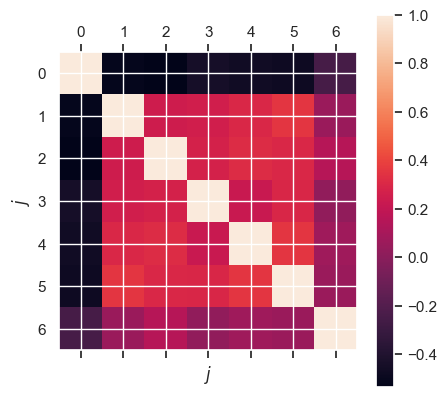

In [357]:

plt.matshow(corr, cmap="rocket")
plt.colorbar()
plt.xlabel(r"$j$")
plt.ylabel(r"$j$")
plt.show()

In [ ]:
# facility transmission rate is negatively correlated with everything else
# floor rates are positively correlated
# room rate is essentially uncorrelated with floor rates